In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
import joblib

In [2]:
from google.colab import files
uploaded = files.upload()

Saving preprocessed.csv to preprocessed.csv


In [5]:
import io

data = pd.read_csv(io.BytesIO(uploaded['preprocessed.csv']))

In [6]:
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Date_month,Date_day
0,2008-12-01,30,13.4,22.9,0.6,2.4,8.3,4.0,44.0,5.0,...,1007.7,1007.1,8.0,7.0,16.9,21.8,0,0,12,1
1,2008-12-02,30,7.4,25.1,0.0,3.6,10.0,2.0,44.0,0.0,...,1010.6,1007.8,7.0,7.0,17.2,24.3,0,0,12,2
2,2008-12-03,30,12.9,25.7,0.0,2.6,4.4,5.0,46.0,5.0,...,1007.6,1008.7,7.0,2.0,21.0,23.2,0,0,12,3
3,2008-12-04,30,9.2,28.0,0.0,14.6,8.9,11.0,24.0,13.0,...,1017.6,1012.8,7.0,7.0,18.1,26.5,0,0,12,4
4,2008-12-05,30,17.5,32.3,1.0,5.4,3.0,4.0,41.0,12.0,...,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0,12,5


In [7]:
data.shape

(145460, 25)

In [8]:
df = data.sample(n = 12000)

In [9]:
df.shape

(12000, 25)

In [10]:
X = df.drop(["RainTomorrow", "Date"], axis=1)
y = df["RainTomorrow"]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.2, stratify = y, random_state = 0)

In [12]:
y_train

,RainTomorrow
89887,0
102363,0
57734,0
70134,1
120167,0
...,...
56134,0
13620,0
11328,0
80129,0


<Axes: ylabel='count'>

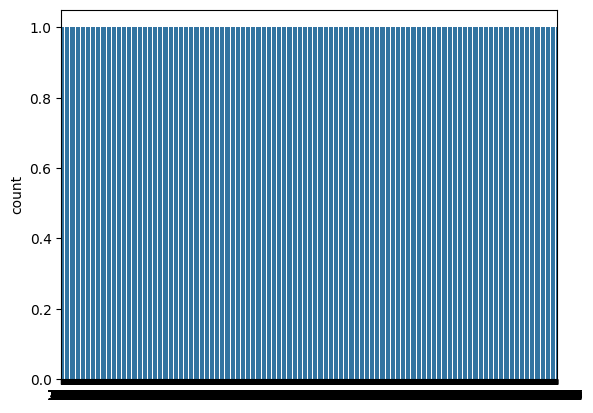

In [13]:
sns.countplot(df["RainTomorrow"])

In [14]:
sm=SMOTE(random_state=0)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_res)))

The number of classes before fit Counter({0: 7506, 1: 2094})
The number of classes after fit Counter({0: 7506, 1: 7506})


In [15]:
xgb = XGBClassifier()
xgb.fit(X_train_res, y_train_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [16]:
y_pred = xgb.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[1758  118]
 [ 239  285]]
0.85125
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1876
           1       0.71      0.54      0.61       524

    accuracy                           0.85      2400
   macro avg       0.79      0.74      0.76      2400
weighted avg       0.84      0.85      0.84      2400



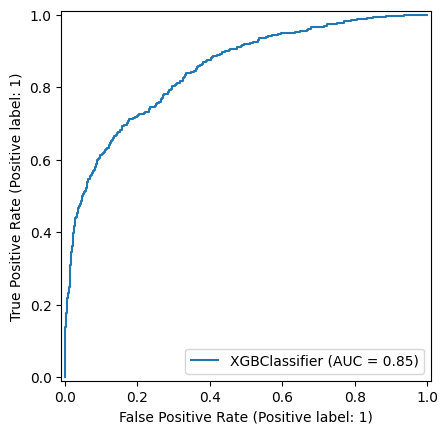

In [23]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(xgb, X_test, y_test)


In [24]:
#Randomized Search CV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Various learning rate parameters
learning_rate = ['0.05','0.1', '0.2','0.3','0.5','0.6']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# max_depth.append(None)
#Subssample parameter values
subsample=[0.7,0.6,0.8]
# Minimum child weight parameters
min_child_weight=[3,4,5,6,7]

In [25]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'subsample': subsample,
               'min_child_weight': min_child_weight}

print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200], 'learning_rate': ['0.05', '0.1', '0.2', '0.3', '0.5', '0.6'], 'max_depth': [5, 10, 15, 20, 25, 30], 'subsample': [0.7, 0.6, 0.8], 'min_child_weight': [3, 4, 5, 6, 7]}


In [26]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
classifier = XGBClassifier()

In [27]:
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations
xg_random = RandomizedSearchCV(estimator = classifier, param_distributions = random_grid, n_iter = 25, cv = 3, verbose=2, random_state=100, n_jobs = -1)

In [28]:
xg_random.fit(X_train_res, y_train_res)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'learning_rate': ['0.05', '0.1', '0.2',
                                                          '0.3', '0.5', '0.6'],
                                        'max_depth': [5, 10, 15, 20, 25, 30],
                                        'min_child_weight': [3, 4, 5, 6, 7],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200],
                                        'subsample': [0.7, 0.6, 0.8]},
                   random_state=100, verbose=2)

In [29]:
xg_random.best_params_

{'subsample': 0.6,
 'n_estimators': 400,
 'min_child_weight': 5,
 'max_depth': 25,
 'learning_rate': '0.05'}

In [30]:
xg_random.best_score_

0.8439914734878764

In [31]:
from sklearn.metrics import accuracy_score
y_predict = xg_random.predict(X_test)
print(confusion_matrix(y_test,y_predict))
print('Accuracy score {}'.format(accuracy_score(y_test,y_predict)))
print('Classification report {}'.format(classification_report(y_test,y_predict)))

[[1740  136]
 [ 223  301]]
Accuracy score 0.8504166666666667
Classification report               precision    recall  f1-score   support

           0       0.89      0.93      0.91      1876
           1       0.69      0.57      0.63       524

    accuracy                           0.85      2400
   macro avg       0.79      0.75      0.77      2400
weighted avg       0.84      0.85      0.85      2400



In [32]:
joblib.dump(xgb, "xg_random.pkl")

['xg_random.pkl']